In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the column names (feature names)
# Unit, time cycle, three setting parameters, 21 sensors
columns = ['UnitNumber', 'TimeInCycles', 
           'Setting1', 'Setting2', 'Setting3'] + \
          [f'Sensor{i}' for i in range(1, 22)]

# Adjust data path if you are not using FD001
data_path = '../data/raw/train_FD001.txt' 

# Load the training data
# The dataset has no header, so 'header=None' and the separator is a space
df = pd.read_csv(data_path, sep='\s+', header=None, names=columns)

# Show the first 5 rows
print("Data structure:")
print(df.head())
print("\nStatistical overview:")
print(df.describe().transpose())

Data structure:
   UnitNumber  TimeInCycles  Setting1  Setting2  Setting3  Sensor1  Sensor2  \
0           1             1   -0.0007   -0.0004     100.0   518.67   641.82   
1           1             2    0.0019   -0.0003     100.0   518.67   642.15   
2           1             3   -0.0043    0.0003     100.0   518.67   642.35   
3           1             4    0.0007    0.0000     100.0   518.67   642.35   
4           1             5   -0.0019   -0.0002     100.0   518.67   642.37   

   Sensor3  Sensor4  Sensor5  ...  Sensor12  Sensor13  Sensor14  Sensor15  \
0  1589.70  1400.60    14.62  ...    521.66   2388.02   8138.62    8.4195   
1  1591.82  1403.14    14.62  ...    522.28   2388.07   8131.49    8.4318   
2  1587.99  1404.20    14.62  ...    522.42   2388.03   8133.23    8.4178   
3  1582.79  1401.87    14.62  ...    522.86   2388.08   8133.83    8.3682   
4  1582.85  1406.22    14.62  ...    522.19   2388.04   8133.80    8.4294   

   Sensor16  Sensor17  Sensor18  Sensor19  Sen


Data with RUL column:
       UnitNumber  TimeInCycles  Setting1  Setting2  Setting3  Sensor1  \
20626         100           196   -0.0004   -0.0003     100.0   518.67   
20627         100           197   -0.0016   -0.0005     100.0   518.67   
20628         100           198    0.0004    0.0000     100.0   518.67   
20629         100           199   -0.0011    0.0003     100.0   518.67   
20630         100           200   -0.0032   -0.0005     100.0   518.67   

       Sensor2  Sensor3  Sensor4  Sensor5  ...  Sensor14  Sensor15  Sensor16  \
20626   643.49  1597.98  1428.63    14.62  ...   8137.60    8.4956      0.03   
20627   643.54  1604.50  1433.58    14.62  ...   8136.50    8.5139      0.03   
20628   643.42  1602.46  1428.18    14.62  ...   8141.05    8.5646      0.03   
20629   643.23  1605.26  1426.53    14.62  ...   8139.29    8.5389      0.03   
20630   643.85  1600.38  1432.14    14.62  ...   8137.33    8.5036      0.03   

       Sensor17  Sensor18  Sensor19  Sensor20  Sens

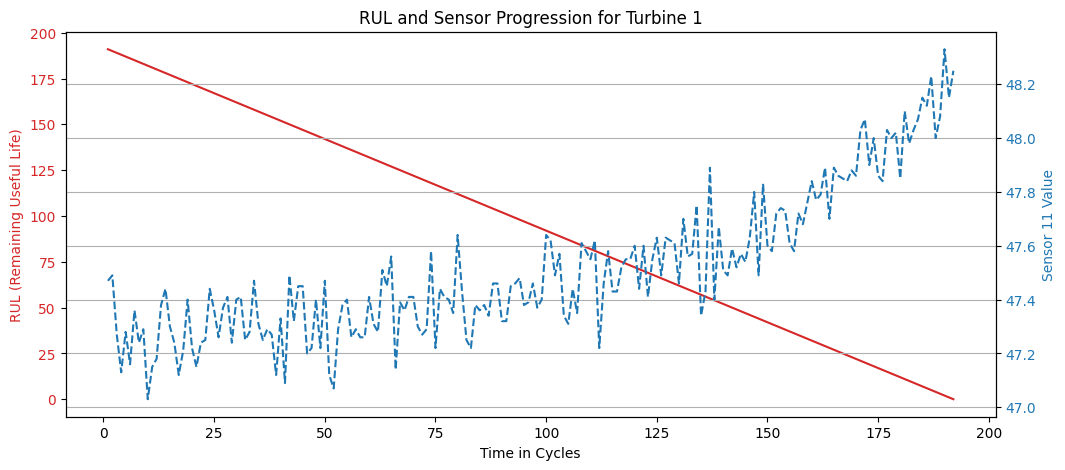

In [4]:
# Calculate the maximum cycle for each unit
max_cycles = df.groupby('UnitNumber')['TimeInCycles'].max().reset_index()
max_cycles.columns = ['UnitNumber', 'MaxTime']

# Add the maximum time back into the main DataFrame
df = df.merge(max_cycles, on='UnitNumber', how='left')

# Calculate RUL (Remaining Useful Life): MaxTime - TimeInCycles
df['RUL'] = df['MaxTime'] - df['TimeInCycles']

print("\nData with RUL column:")
print(df.tail())

# Now we plot the RUL and an interesting sensor for ONE turbine (e.g., Turbine 1)
unit_id = 1
df_unit = df[df['UnitNumber'] == unit_id]

# Plot: RUL vs. Time
fig, ax1 = plt.subplots(figsize=(12, 5))

# Axis 1: RUL (target variable)
color = 'tab:red'
ax1.set_xlabel('Time in Cycles')
ax1.set_ylabel('RUL (Remaining Useful Life)', color=color)
ax1.plot(df_unit['TimeInCycles'], df_unit['RUL'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Axis 2: A meaningful sensor (e.g., Sensor 11: Fan pressure ratio)
ax2 = ax1.twinx() # Axes share the X-axis
color = 'tab:blue'
ax2.set_ylabel('Sensor 11 Value', color=color) 
ax2.plot(df_unit['TimeInCycles'], df_unit['Sensor11'], color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'RUL and Sensor Progression for Turbine {unit_id}')
plt.grid(True)
plt.show()

In [5]:
def create_physical_features(df):
    """
    Creates three new, physically motivated features based on the sensor data 
    for improved RUL prediction.
    """
    df_new = df.copy()

    # --- 1. HPC Efficiency Proxy (Total Pressure / Total Temperature) ---
    # Sensor 12: Total pressure at High Pressure Turbine (T4)
    # Sensor 7: Total temperature at High Pressure Compressor (T2)
    df_new['Effizienz_HPC_Proxy'] = df_new['Sensor12'] / df_new['Sensor7']

    # --- 2. Exhaust Gas Temperature Drift (EGT Drift) ---
    # Sensor 17: Exhaust Gas Temperature (EGT)
    
    # Calculate the mean of Sensor 17 for the first 10 cycles of each unit 
    # as the "healthy" baseline reference.
    df_ref = df_new[df_new['TimeInCycles'] <= 10].groupby('UnitNumber')['Sensor17'].mean().reset_index()
    df_ref.rename(columns={'Sensor17': 'Sensor17_Base'}, inplace=True)
    
    # Merge the baseline back into the main DataFrame
    df_new = pd.merge(df_new, df_ref, on='UnitNumber', how='left')
    
    # Calculate the Drift: (Current Value - Healthy Baseline)
    df_new['EGT_Drift'] = df_new['Sensor17'] - df_new['Sensor17_Base']
    
    # Cleanup: remove the temporary base column
    df_new.drop(columns=['Sensor17_Base'], inplace=True)


    # --- 3. Fan-HPC Degradation Ratio ---
    # Sensor 2: Fan Speed
    # Sensor 3: HPC Speed
    df_new['Fan_HPC_Ratio'] = df_new['Sensor2'] / df_new['Sensor3']

    print(f"New columns successfully added. Current number of columns: {len(df_new.columns)}")
    print(df_new[['Effizienz_HPC_Proxy', 'EGT_Drift', 'Fan_HPC_Ratio', 'RUL']].head())
    
    return df_new

In [6]:
def add_trend_features(df):
    """
    Add simple trend/dynamic features per unit based on EGT_Drift and Fan_HPC_Ratio.
    Assumes df already contains:
        - 'UnitNumber'
        - 'TimeInCycles'
        - 'EGT_Drift'
        - 'Fan_HPC_Ratio'
    """
    df = df.copy()
    
    # Ensure proper sorting
    df = df.sort_values(['UnitNumber', 'TimeInCycles'])
    
    # Function applied per unit
    def _add_trends(group):
        # Rolling mean over last 5 cycles
        group['EGT_Drift_ma5'] = group['EGT_Drift'].rolling(window=5, min_periods=1).mean()
        group['Fan_HPC_Ratio_ma5'] = group['Fan_HPC_Ratio'].rolling(window=5, min_periods=1).mean()
        
        # Simple slope: difference of rolling mean
        group['EGT_Drift_slope'] = group['EGT_Drift_ma5'].diff().fillna(0.0)
        group['Fan_HPC_Ratio_slope'] = group['Fan_HPC_Ratio_ma5'].diff().fillna(0.0)
        
        return group
    
    df = df.groupby('UnitNumber', group_keys=False).apply(_add_trends)
    
    print("Trend features added:")
    print(df[['EGT_Drift', 'EGT_Drift_ma5', 'EGT_Drift_slope',
              'Fan_HPC_Ratio', 'Fan_HPC_Ratio_ma5', 'Fan_HPC_Ratio_slope']].head())
    
    return df


In [7]:
# generate new features
df= create_physical_features(df)
#df= add_trend_features(df)

print("\nData structure with new features:")
print(df.head())

New columns successfully added. Current number of columns: 31
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.941013        0.2       0.403737  191
1             0.943169        0.2       0.403406  190
2             0.942554       -1.8       0.404505  189
3             0.943025        0.2       0.405834  188
4             0.942581        1.2       0.405831  187

Data structure with new features:
   UnitNumber  TimeInCycles  Setting1  Setting2  Setting3  Sensor1  Sensor2  \
0           1             1   -0.0007   -0.0004     100.0   518.67   641.82   
1           1             2    0.0019   -0.0003     100.0   518.67   642.15   
2           1             3   -0.0043    0.0003     100.0   518.67   642.35   
3           1             4    0.0007    0.0000     100.0   518.67   642.35   
4           1             5   -0.0019   -0.0002     100.0   518.67   642.37   

   Sensor3  Sensor4  Sensor5  ...  Sensor17  Sensor18  Sensor19  Sensor20  \
0  1589.70  1400.60    14.6

In [8]:
# List of columns that are constant (or quasi-constant) and will be removed
cols_to_drop = ['Setting3', 'Sensor1', 'Sensor5', 'Sensor6', 
                'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19'] 

# We also remove the auxiliary columns 'MaxTime' and 'TimeInCycles' for training,
# since RUL was calculated directly from these (and RUL is our y).
df_processed = df.drop(columns=['MaxTime', 'TimeInCycles'] + cols_to_drop)
print(f"Data shape after feature selection: {df_processed.shape}")

Data shape after feature selection: (20631, 21)


In [9]:
from sklearn.preprocessing import MinMaxScaler

# We normalize ALL columns, except UnitNumber and RUL (our y).
# We save the MinMaxScaler, as we will need it later for new test data.
scaler = MinMaxScaler()

# The columns to be normalized (everything except UnitNumber and RUL)
cols_to_scale = df_processed.columns.drop(['UnitNumber', 'RUL'])

# Normalize the data and replace the columns in the DataFrame
df_processed[cols_to_scale] = scaler.fit_transform(df_processed[cols_to_scale])

print("\nData structure after normalization (values 0 to 1):")
print(df_processed.head())
print(scaler.feature_names_in_)


Data structure after normalization (values 0 to 1):
   UnitNumber  Setting1  Setting2   Sensor2   Sensor3   Sensor4   Sensor7  \
0           1  0.459770  0.166667  0.183735  0.406802  0.309757  0.726248   
1           1  0.609195  0.250000  0.283133  0.453019  0.352633  0.628019   
2           1  0.252874  0.750000  0.343373  0.369523  0.370527  0.710145   
3           1  0.540230  0.500000  0.343373  0.256159  0.331195  0.740741   
4           1  0.390805  0.333333  0.349398  0.257467  0.404625  0.668277   

    Sensor8   Sensor9  Sensor11  ...  Sensor13  Sensor14  Sensor15  Sensor17  \
0  0.242424  0.109755  0.369048  ...  0.205882  0.199608  0.363986  0.333333   
1  0.212121  0.100242  0.380952  ...  0.279412  0.162813  0.411312  0.333333   
2  0.272727  0.140043  0.250000  ...  0.220588  0.171793  0.357445  0.166667   
3  0.318182  0.124518  0.166667  ...  0.294118  0.174889  0.166603  0.333333   
4  0.242424  0.149960  0.255952  ...  0.235294  0.174734  0.402078  0.416667   

   

In [10]:
def create_sequences(df_unit, sequence_length):
    """
    Converts the time series data of a single turbine into sequences.
    """
    X, y = [], []
    features = df_unit.drop(columns=['UnitNumber', 'RUL']).values # Only the normalized sensors
    # IMPORTANT: Define the clamping value (hyperparameter)
    rul = df_unit['RUL'].values
    MAX_RUL = 125 

    # Perform the clamping: RUL is at most MAX_RUL
    df['RUL'] = df['RUL'].clip(upper=MAX_RUL)

    print(f"\nMaximum RUL value after clamping: {df['RUL'].max()}")

    for i in range(len(features) - sequence_length + 1):
        # X: The sensor data of the last 'sequence_length' cycles
        X.append(features[i:i + sequence_length])
        
        # y: The RUL value of the LAST cycle in this sequence
        y.append(rul[i + sequence_length - 1])
        
    return np.array(X), np.array(y)

# Define the sequence length (sliding window). 
# We take e.g. 30 cycles of history to predict RUL.
SEQUENCE_LENGTH = 30 

# Perform sequence creation for ALL units
X_data, y_data = [], []

for unit_id in df_processed['UnitNumber'].unique():
    df_unit = df_processed[df_processed['UnitNumber'] == unit_id]
    
    # Ignore units that are shorter than the sequence length
    if len(df_unit) >= SEQUENCE_LENGTH:
        X_unit, y_unit = create_sequences(df_unit, SEQUENCE_LENGTH)
        X_data.append(X_unit)
        y_data.append(y_unit)

# Concatenate the data from all units
X_final = np.concatenate(X_data, axis=0)
y_final = np.concatenate(y_data, axis=0)

print(f"\nFinal data shape for PyTorch input:")
print(f"X (Input sequences): {X_final.shape}")
print(f"y (Output RUL values): {y_final.shape}")


Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after clamping: 125

Maximum RUL value after 

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 1. Convert NumPy arrays to PyTorch tensors
# We need Float32 for training
X_tensor = torch.tensor(X_final, dtype=torch.float32)
y_tensor = torch.tensor(y_final, dtype=torch.float32).unsqueeze(1) # Unsqueeze(1) adds a dimension (important for regression)

# 2. Split data into training and validation (e.g., 80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# 3. Create DataLoaders
# These help pass the data efficiently to the model in small "batches".
BATCH_SIZE = 64 # A typical batch size

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation data points: {len(y_val)}")

Number of training batches: 222
Number of validation data points: 3547


In [12]:
import torch.nn as nn

# We determine the input and output sizes
# X_final.shape was (N, SEQUENCE_LENGTH, NUMBER_OF_FEATURES)
INPUT_SIZE = X_final.shape[2] # Number of sensors (features)
HIDDEN_SIZE = 50              # Number of neurons in the LSTM layer (hyperparameter)
NUM_LAYERS = 2                # Number of LSTM layers stacked on top of each other (Deep Learning!)
OUTPUT_SIZE = 1               # We only predict one number: RUL

class LSTMRULPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMRULPredictor, self).__init__()
        
        # 1. The LSTM layer: Processes the sequence
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True # Important: Batch dimension is first (Batch, Sequence, Features)
        )
        
        # 2. The final layer (Fully Connected): 
        # Reduces the LSTM output to our desired RUL value (Output_Size=1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 'h_n' and 'c_n' are the Hidden and Cell states (not directly needed here)
        # 'output' is the output of the LSTM layer for EACH time step
        output, (h_n, c_n) = self.lstm(x)
        
        # We are only interested in the output of the LAST time step of the sequence
        # as this represents the accumulated state of the entire history.
        last_output = output[:, -1, :] 
        
        # Pass the last output through the Fully Connected layer to get the RUL
        prediction = self.fc(last_output)
        return prediction



In [13]:
class LSTMRULWithAttention(nn.Module):
    """
    LSTM model with simple attention over time.
    Uses the same hyperparameter interface as the baseline model.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMRULWithAttention, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2  # optional, can be set to 0.0
        )
        
        # Attention: score per time step
        self.attn = nn.Linear(hidden_size, 1)
        
        # Final regression layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (B, T, F)
        lstm_out, _ = self.lstm(x)          # (B, T, H)
        
        # Attention weights over time steps
        attn_scores  = self.attn(lstm_out)  # (B, T, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)  # (B, T, 1)
        
        # Weighted sum over time dimension
        context = (lstm_out * attn_weights).sum(dim=1)    # (B, H)
        
        out = self.fc(context)                            # (B, 1)
        return out


In [14]:
# Choose model type: "baseline" or "attention"
MODEL_TYPE = "baseline"   # oder "baseline"

if MODEL_TYPE == "baseline":
    model = LSTMRULPredictor(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
elif MODEL_TYPE == "attention":
    model = LSTMRULWithAttention(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
else:
    raise ValueError(f"Unknown MODEL_TYPE: {MODEL_TYPE}")

print("\nSelected model type:", MODEL_TYPE)
print("Model architecture:")
print(model)


Selected model type: baseline
Model architecture:
LSTMRULPredictor(
  (lstm): LSTM(19, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [15]:
def rul_asymmetric_weighted_loss(pred, target,
                                 over_factor=2.0,
                                 min_rul_weight=1.0,
                                 max_rul_weight=0.3):
    """
    Custom loss for RUL:
    - Overestimation (pred > target) is penalized stronger than underestimation.
    - Low RUL values are weighted higher than large RUL values.
    """
    pred = pred.view(-1)
    target = target.view(-1)
    
    error = pred - target
    over  = torch.clamp(error, min=0.0)      # overestimation
    under = torch.clamp(-error, min=0.0)     # underestimation
    
    # Asymmetric penalty (like MSE but scaled for overestimation)
    base_loss = over_factor * over**2 + under**2
    
    # RUL-based weights: higher weight for small RUL
    t_norm = target / (target.max() + 1e-6)  # normalize to [0,1]
    # Map to [max_rul_weight, min_rul_weight]
    weights = max_rul_weight + (min_rul_weight - max_rul_weight) * (1.0 - t_norm)
    
    weighted_loss = weights * base_loss
    return weighted_loss.mean()

In [16]:
# Definition of hyperparameters
NUM_EPOCHS = 1
LEARNING_RATE = 0.001 

# Setup
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
def criterion1(pred, target):
    return rul_asymmetric_weighted_loss(
        pred, target,
        over_factor=2.0,
        min_rul_weight=1.0,
        max_rul_weight=0.3
    )

print(f"\nStarting training for {NUM_EPOCHS} epochs...")

# ****************** The Training Loop ******************
for epoch in range(NUM_EPOCHS):
    model.train() # Set the model to training mode
    train_loss = 0.0
    
    # Training over all batches
    for inputs, targets in train_loader:
        # 1. Reset gradients
        optimizer.zero_grad()
        
        # 2. Forward Pass: Make prediction
        outputs = model(inputs)
        
        # 3. Calculate loss
        loss = criterion1(outputs, targets)
        
        # 4. Backward Pass: Calculate gradients
        loss.backward()
        
        # 5. Update weights
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)

    # Calculate average training loss
    epoch_train_loss = train_loss / len(train_dataset)
    
    # ****************** The Validation Loop ******************
    model.eval() # Set the model to validation mode (no gradients)
    val_loss = 0.0
    
    with torch.no_grad(): # Disables gradient computation
        for inputs_val, targets_val in val_loader:
            outputs_val = model(inputs_val)
            loss_val = criterion1(outputs_val, targets_val)
            val_loss += loss_val.item() * inputs_val.size(0)
            
    epoch_val_loss = val_loss / len(val_dataset)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

print("Training completed!")


Starting training for 1 epochs...
Epoch [1/1], Train Loss: 6290.6850, Val Loss: 5459.7070
Training completed!


In [17]:
# Load the test data (replace the path if necessary)
test_data_path = '../data/raw/test_FD001.txt' 
df_test = pd.read_csv(test_data_path, sep='\s+', header=None, names=columns)

# **IMPORTANT:** Here we define again ALL columns that we removed from TRAINING 
# (Setting3, TimeInCycles, MaxTime, etc.)
# We use the same variables as in code block 3
full_cols_to_drop = ['MaxTime', 'TimeInCycles'] + cols_to_drop 

# 1. Feature Selection (Remove the same columns as in training)
# Now we explicitly remove ALL unnecessary columns
df_test['RUL'] = 0 # Dummy value
df_test_processed = create_physical_features(df_test)   # create new features
#df_test_processed = add_trend_features(df_test_processed)
df_test_processed = df_test_processed.drop(columns=full_cols_to_drop, errors='ignore') # 'errors='ignore' prevents errors if a column is missing


# 2. Add RUL column (placeholder for sequence creation)
df_test_processed['UnitNumber'] = df_test_processed['UnitNumber'] 

# 3. Normalization (ONLY transform!)
# The columns to scale are now all features except UnitNumber and RUL
test_cols_to_scale = df_test_processed.columns.drop(['UnitNumber', 'RUL'])

# IMPORTANT: Use the 'scaler' that you created during training!
df_test_processed[test_cols_to_scale] = scaler.transform(df_test_processed[test_cols_to_scale]) 

# 4. Sequence creation (ONLY the last sequence of each unit is relevant for RUL prediction)
X_test_list = []
y_test_list = [] # Here the true RUL values will go (will be loaded later)

for unit_id in df_test_processed['UnitNumber'].unique():
    df_unit = df_test_processed[df_test_processed['UnitNumber'] == unit_id]
    
    # We only take the last sequence of observations (the newest 30 cycles)
    if len(df_unit) >= SEQUENCE_LENGTH:
        X_test_list.append(df_unit.drop(columns=['UnitNumber', 'RUL']).values[-SEQUENCE_LENGTH:])
    # For units that are shorter than 30 cycles, we would need to pad, we skip that here.

X_test_final = np.array(X_test_list)
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)

print(f"Final test shape for PyTorch input: {X_test_tensor.shape}")

New columns successfully added. Current number of columns: 30
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.941903        0.3       0.405617    0
1             0.941083        1.3       0.403985    0
2             0.941997        1.3       0.404842    0
3             0.941000       -0.7       0.405550    0
4             0.942237       -1.7       0.404810    0
Final test shape for PyTorch input: torch.Size([100, 30, 19])


In [18]:
# Load the true RUL values for the test units
true_rul = pd.read_csv('../data/raw/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])
true_rul_values = true_rul['RUL'].values
# NOTE: Insert the MAX_RUL definition here if cell 9 did not run
MAX_RUL = 125
# We must apply the clamping logic here to have a fair comparison!
# We clamp the true RUL values to 125 cycles
y_true_clamped = np.clip(true_rul_values[:len(X_test_tensor)], a_min=None, a_max=MAX_RUL)
y_true_tensor = torch.tensor(y_true_clamped, dtype=torch.float32).unsqueeze(1)

# Set the model to evaluation mode
model.eval() 

with torch.no_grad():
    # Make the predictions
    y_pred_tensor = model(X_test_tensor)

# Convert back to NumPy for metric calculation
y_pred = y_pred_tensor.squeeze().numpy()
y_true = y_true_tensor.squeeze().numpy()

# Calculate the final Mean Squared Error (MSE) on the test data
test_mse = np.mean((y_pred - y_true)**2)
test_rmse = np.sqrt(test_mse)

print(f"\n--- Final Test Performance (after RUL Clamping) ---")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE (in cycles): {test_rmse:.4f}")
print(f"Predicted RUL for the first 5 turbines: {y_pred[:5].round(1)}")
print(f"True RUL for the first 5 turbines:        {y_true[:5].round(1)}")


--- Final Test Performance (after RUL Clamping) ---
Test MSE: 5134.1436
Test RMSE (in cycles): 71.6529
Predicted RUL for the first 5 turbines: [15.1 15.1 15.1 15.1 15.1]
True RUL for the first 5 turbines:        [112.  98.  69.  82.  91.]


In [19]:
# Evaluation block:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
# -------------------------------------------------------------------
# 1) Load test data (same column definition as in training)
# -------------------------------------------------------------------
test_data_path = 'data/test_FD001.txt'

# 'columns' comes from your training code – reuse it here
df_test = pd.read_csv(test_data_path, sep=r'\s+', header=None, names=columns)

# -------------------------------------------------------------------
# 2) Create physical features on the *unscaled* test data
# -------------------------------------------------------------------
# Add dummy RUL column for consistency with your pipeline
df_test['RUL'] = 0  
# create_physical_features is your function from before
df_test_phys = create_physical_features(df_test.copy())
#df_test_phys = add_trend_features(df_test_phys)


# -------------------------------------------------------------------
# 3) Drop same columns as in training and normalize
# -------------------------------------------------------------------
# full_cols_to_drop: MaxTime, TimeInCycles and your existing cols_to_drop list
full_cols_to_drop = ['MaxTime', 'TimeInCycles'] + cols_to_drop

# For model input: drop these columns
df_test_processed = df_test_phys.drop(columns=full_cols_to_drop, errors='ignore')

# Keep UnitNumber
df_test_processed['UnitNumber'] = df_test_phys['UnitNumber']

# Columns to scale: everything except UnitNumber and RUL
test_cols_to_scale = df_test_processed.columns.drop(['UnitNumber', 'RUL'])

# IMPORTANT: use the scaler fitted on the training data
df_test_processed[test_cols_to_scale] = scaler.transform(df_test_processed[test_cols_to_scale])

# -------------------------------------------------------------------
# 4) Build sequences for the model (last sequence per unit)
# -------------------------------------------------------------------
X_test_list = []
unit_ids_test = []

for unit_id in sorted(df_test_processed['UnitNumber'].unique()):
    df_unit = df_test_processed[df_test_processed['UnitNumber'] == unit_id]
    
    # Only use units with at least SEQUENCE_LENGTH cycles
    if len(df_unit) >= SEQUENCE_LENGTH:
        X_test_list.append(
            df_unit.drop(columns=['UnitNumber', 'RUL']).values[-SEQUENCE_LENGTH:]
        )
        unit_ids_test.append(unit_id)

X_test_final = np.array(X_test_list)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32).to(device)

print(f"Final test shape for PyTorch input: {X_test_tensor.shape}")

# -------------------------------------------------------------------
# 5) Predict RUL for test set
# -------------------------------------------------------------------
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy().reshape(-1)

# Optional: apply the same clamping as in your evaluation (e.g. 125 cycles)
y_test_pred = np.minimum(y_test_pred, 125.0)

# -------------------------------------------------------------------
# 6) Load true RUL values
# -------------------------------------------------------------------
rul_path = 'data/RUL_FD001.txt'
rul_df = pd.read_csv(rul_path, sep=r'\s+', header=None)
y_test_true = rul_df[0].values.astype(float)

# Apply same clamping as you do in training/evaluation
y_test_true = np.minimum(y_test_true, 125.0)

print(f"len(y_test_true) = {len(y_test_true)}, len(y_test_pred) = {len(y_test_pred)}")

# -------------------------------------------------------------------
# 7) Get last row per unit for result CSV (incl. physical features)
# -------------------------------------------------------------------
# df_test_phys contains UnitNumber, TimeInCycles, Effizienz_HPC_Proxy, EGT_Drift, Fan_HPC_Ratio, etc.

df_last = (
    df_test_phys
    .sort_values(['UnitNumber', 'TimeInCycles'])
    .groupby('UnitNumber')
    .tail(1)
    .sort_values('UnitNumber')
)

# For FD001, the order of units in RUL_FD001.txt is typically 1..N,
# so lengths and ordering should match:
assert len(df_last) == len(y_test_true) == len(y_test_pred)

# -------------------------------------------------------------------
# 8) Build results DataFrame and save as CSV
# -------------------------------------------------------------------
results_df = pd.DataFrame({
    "UnitNumber": df_last["UnitNumber"].values,
    "TimeInCycles": df_last["TimeInCycles"].values,
    "TrueRUL": y_test_true,
    "PredRUL": y_test_pred,
    "Effizienz_HPC_Proxy": df_last["Effizienz_HPC_Proxy"].values,
    "EGT_Drift": df_last["EGT_Drift"].values,
    "Fan_HPC_Ratio": df_last["Fan_HPC_Ratio"].values,
})

os.makedirs("results", exist_ok=True)
results_path = "results/fd001_predictions_physical_features.csv"
results_df.to_csv(results_path, index=False)

print(f"Saved evaluation data to {results_path}")
print(results_df.head())



FileNotFoundError: [Errno 2] No such file or directory: 'data/test_FD001.txt'